In [ ]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 10.2 MB/s eta 0:00:00



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

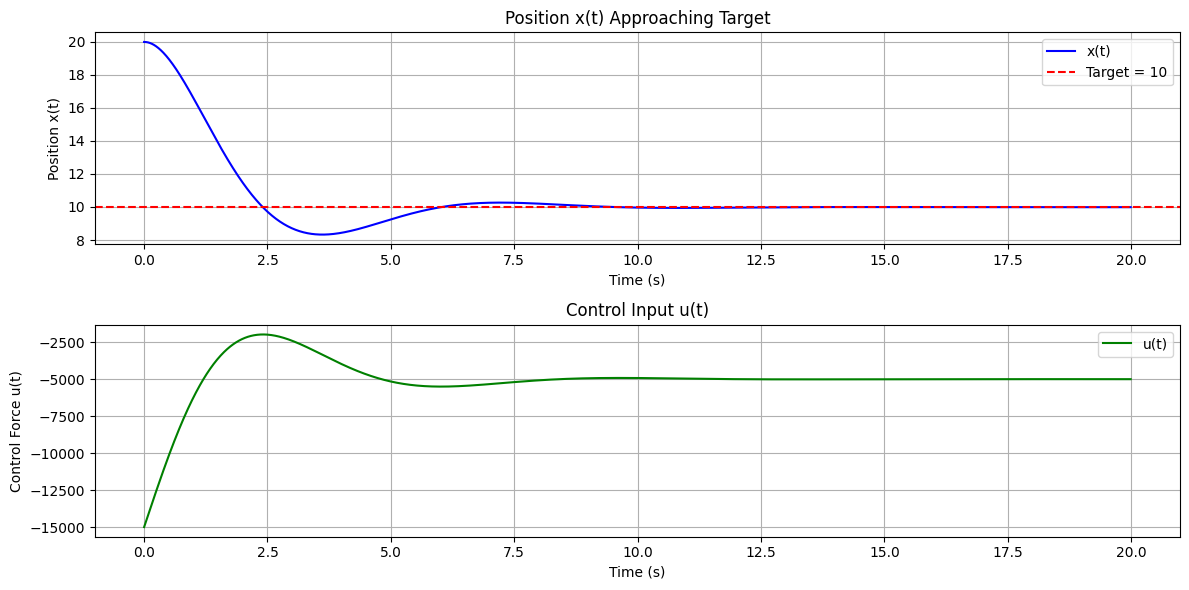

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m, n, k = 1000.0, 0.5, 1.00  # Mass, damping, and stiffness
t_end = 20               # Simulation time
dt = 0.01                # Time step

# Define symbolic variables
x = ca.MX.sym("x")       # Position
v = ca.MX.sym("v")       # Velocity
states = ca.vertcat(x, v)  # State vector
u = ca.MX.sym("u")       # Control input

# Dynamics: dx/dt = v, dv/dt = (u - nv - kx) / m
x_dot = v
v_dot = (u - n * v - k * x) / m
dynamics = ca.vertcat(x_dot, v_dot)

# Symbols for control gains
K_p = ca.MX.sym("K_p")
K_d = ca.MX.sym("K_d")

# Define control law with symbolic gains
u_control = -K_p * (x - 10) - K_d * v

# Substitute control law into dynamics
dynamics_controlled = ca.substitute(dynamics, u, u_control)

# Create CasADi function for controlled dynamics
ode = ca.Function("ode", [states, K_p, K_d], [dynamics_controlled])

# Optimization: Define cost function
N = int(t_end / dt)
cost = 0
state = ca.MX([10.0, 0.0])  # Initial conditions
for i in range(N):
    error = state[0] - 10  # Position error
    cost += error**2 * dt  # Squared error integrated over time
    state_dot = ode(state, K_p, K_d)
    state = state + dt * state_dot

# Define the NLP problem
nlp = {"x": ca.vertcat(K_p, K_d), "f": cost}
solver = ca.nlpsol("solver", "ipopt", nlp)

# Solve for optimal K_p and K_d
res = solver(x0=[20, 0], lbx=[0, 0], ubx=[1000, 1000])  # Initial guess and bounds
K_p_opt, K_d_opt = res["x"].full().flatten()

print("Optimized K_p:", K_p_opt, "Optimized K_d:", K_d_opt)

# Simulation with optimized gains
time = np.arange(0, t_end, dt)
x_vals, v_vals, u_vals = [], [], []

# Initial conditions
state = np.array([20.0, 0.0])  # Initial position and velocity

# Numerical integration using Euler's method
for t_step in time:
    x_vals.append(state[0])  # Save position x(t)
    v_vals.append(state[1])  # Save velocity v(t)

    # Compute control input with optimized gains
    u_val = -K_p_opt * (state[0] - 5) - K_d_opt * state[1]
    u_vals.append(u_val)

    # Compute state derivatives and update
    state_dot = ode(state, K_p_opt, K_d_opt)
    state = state + dt * np.array(state_dot.full().flatten())

# Plot results
plt.figure(figsize=(12, 6))

# Position plot
plt.subplot(2, 1, 1)
plt.plot(time, x_vals, label="x(t)", color="blue")
plt.axhline(10, color="red", linestyle="--", label="Target = 10")
plt.title("Position x(t) Approaching Target")
plt.xlabel("Time (s)")
plt.ylabel("Position x(t)")
plt.legend()
plt.grid()

# Control input plot
plt.subplot(2, 1, 2)
plt.plot(time, u_vals, label="u(t)", color="green")
plt.title("Control Input u(t)")
plt.xlabel("Time (s)")
plt.ylabel("Control Force u(t)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


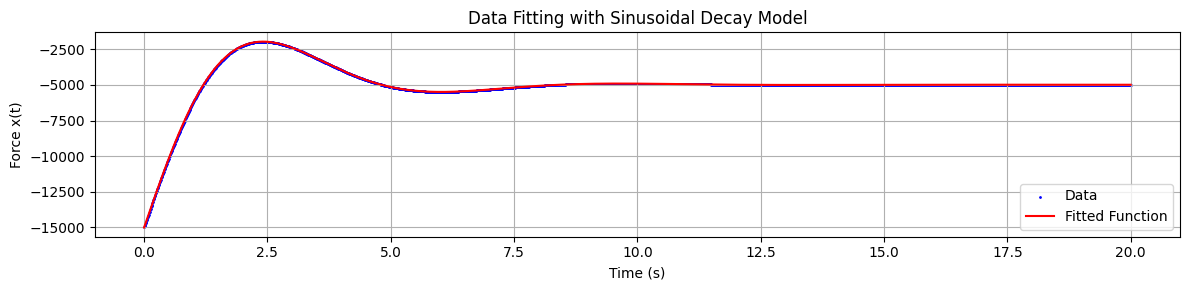

Fitted Parameters: [ 1.15614109e+04  8.70358266e-01 -6.38786204e+01  4.97462857e-01
 -4.99000879e+03]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Generate example data
x_data = np.linspace(0, 20, 2000)
y_data = np.array(u_vals)

# Define the model function
def model(x, a, b, c, d, x0):
    return a * np.sin(b * x + c) * np.exp(-d * x) + x0

# Initial guesses for parameters
initial_guess = [0.5, 2 * np.pi, 0.0, 0.1, 0.5]

# Fit the model to the data
try:
    params, params_covariance = curve_fit(model, x_data, y_data, p0=initial_guess, maxfev=10000)
except RuntimeError as e:
    print(f"Curve fit failed: {e}")
    params = initial_guess  # Use the initial guess as a fallback
func = model(x_data, *params)
# Plot the data and the fitted function
plt.figure(figsize=(12, 3))
plt.scatter(x_data, y_data, label="Data", color="blue", s=1)
plt.plot(x_data, model(x_data, *params) , label="Fitted Function", color="red")
plt.legend()
plt.title("Data Fitting with Sinusoidal Decay Model")
plt.xlabel("Time (s)")
plt.ylabel("Force x(t)")
plt.grid()
plt.tight_layout()
plt.show()

print("Fitted Parameters:", params)


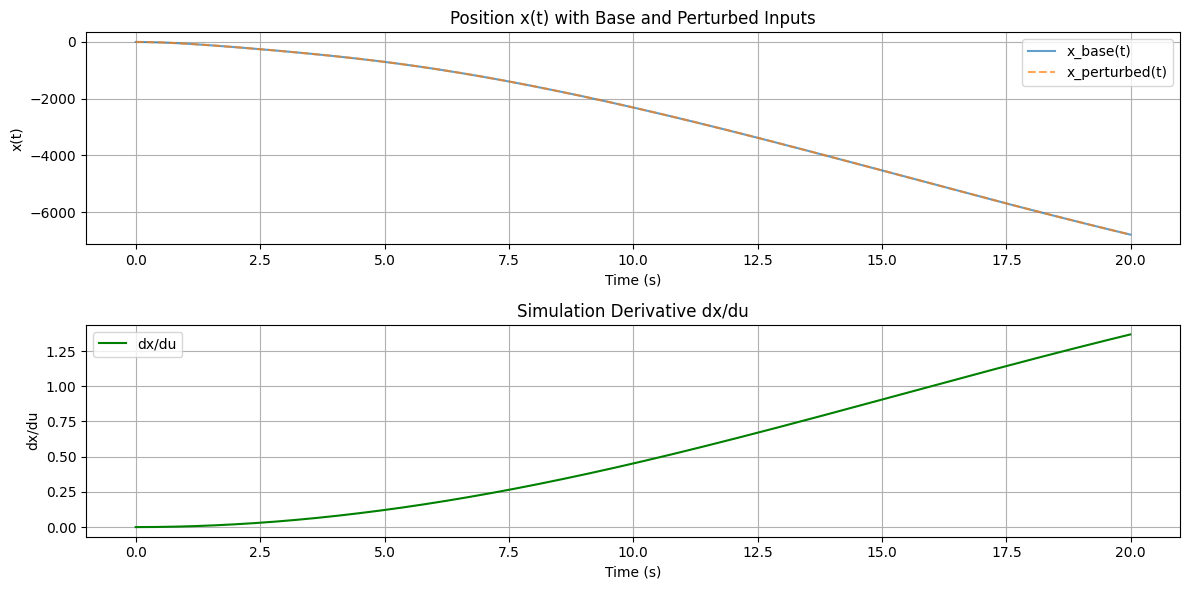

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
m, n, k = 100.0, 0.5, 1.01
t_end = 20
dt = 0.01
time = np.arange(0, t_end, dt)

# Define the system dynamics
def system_dynamics(t, state, u_func):
    """
    System dynamics with a time-varying control input u(t).
    """
    x, v = state
    u = u_func(t)  # Evaluate u(t) at the current time
    dxdt = v
    dvdt = (u - n * v - k * x) / m
    return [dxdt, dvdt]

# Control input function (sinusoidal decay model)
[a, b, c, d, x0_offset] = [11561.4109, 0.870358266, -63.8786204, 0.497462857, -4990.00879]
u_func = lambda t: a * np.sin(b * t + c) * np.exp(-d * t) + x0_offset

# Initial conditions
initial_state = [0.0, 0.0]  # Initial state: [x(0), v(0)]

# Simulate for the original input
sol_base = solve_ivp(
    system_dynamics, [0, t_end], initial_state, t_eval=time, args=(u_func,)
)
x_base = sol_base.y[0]  # Extract position

# Simulate for a perturbed input
delta_u = 0.01
u_func_perturbed = lambda t: u_func(t) + delta_u  # Perturbed control input
sol_perturbed = solve_ivp(
    system_dynamics, [0, t_end], initial_state, t_eval=time, args=(u_func_perturbed,)
)
x_perturbed = sol_perturbed.y[0]  # Extract perturbed position

# Compute the simulation derivative
dx_du = (x_perturbed - x_base) / delta_u

# Plot results
plt.figure(figsize=(12, 6))

# Position x(t)
plt.subplot(2, 1, 1)
plt.plot(time, x_base, label="x_base(t)", alpha=0.7)
plt.plot(time, x_perturbed, label="x_perturbed(t)", linestyle="--", alpha=0.7)
plt.title("Position x(t) with Base and Perturbed Inputs")
plt.xlabel("Time (s)")
plt.ylabel("x(t)")
plt.legend()
plt.grid()

# Simulation derivative dx/du
plt.subplot(2, 1, 2)
plt.plot(time, dx_du, label="dx/du", color="green")
plt.title("Simulation Derivative dx/du")
plt.xlabel("Time (s)")
plt.ylabel("dx/du")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


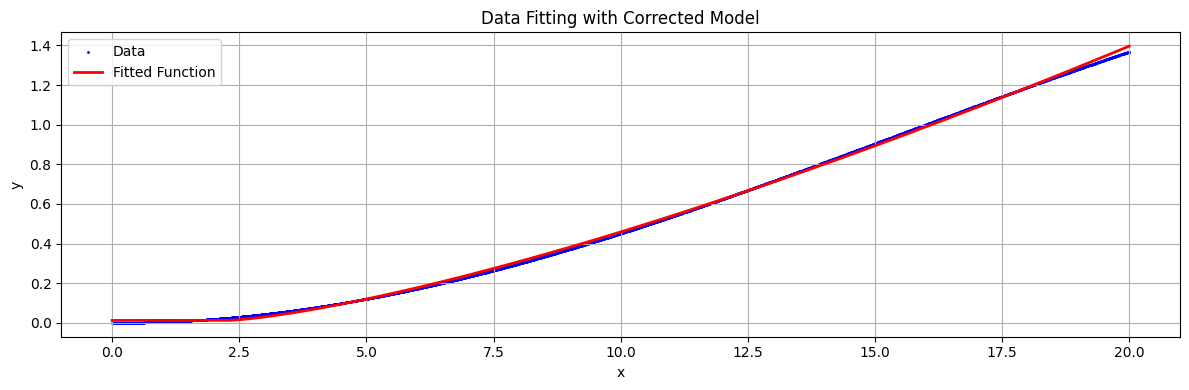

Fitted Parameters: [0.02754032 1.36245054 0.01236006 2.27537185]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Generate example data
x_data = np.linspace(0, 20, 2000)
y_data = np.array(dx_du)  # Replace this with your actual data

# Define the model function
def model(x, a, b, c, d):
    # Ensure positivity of the base to avoid invalid values in power
    base = np.maximum(x - d, 1e-8)  # Add a small value to avoid zero
    return a * base**b + c

# Initial guesses for parameters
initial_guess = [1.0, 1.0, 0.0, 1.0]

# Fit the model to the data
try:
    params, params_covariance = curve_fit(
        model, x_data, y_data, p0=initial_guess, maxfev=50000
    )
except RuntimeError as e:
    print(f"Curve fit failed: {e}")
    params = initial_guess  # Use the initial guess as a fallback

# Evaluate the fitted function
fitted_curve = model(x_data, *params)

# Plot the data and the fitted function
plt.figure(figsize=(12, 4))
plt.scatter(x_data, y_data, label="Data", color="blue", s=1)
plt.plot(x_data, fitted_curve, label="Fitted Function", color="red", linewidth=2)
plt.legend()
plt.title("Data Fitting with Corrected Model")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.tight_layout()
plt.show()

# Display the fitted parameters
print("Fitted Parameters:", params)
